Install opencv `brew install python opencv`  
Install jupyter `pip3 install bokeh matplotlib jupyter simplecoremidi`  
`cd ` here  
`jupyter notebook`


In [9]:
from __future__ import print_function

from time import sleep

import numpy as np
import cv2 as cv
from opencv_py_examples import video

%matplotlib inline
from matplotlib import pyplot as plt


def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# https://en.wikipedia.org/wiki/HSV_color_space
def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    # https://en.wikipedia.org/wiki/Atan2
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*8, 255)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return bgr

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv.remap(img, flow, None, cv.INTER_LINEAR)
    return res

bins = np.arange(256).reshape(256,1)
def hist_curve(im):
    h = np.zeros((300,256,3))
    if len(im.shape) == 2:
        color = [(255,255,255)]
    elif im.shape[2] == 3:
        color = [ (255,0,0),(0,255,0),(0,0,255) ]
    for ch, col in enumerate(color):
        hist_item = cv.calcHist([im],[ch],None,[256],[0,256])
        cv.normalize(hist_item,hist_item,0,255,cv.NORM_MINMAX)
        hist=np.int32(np.around(hist_item))
        pts = np.int32(np.column_stack((bins,hist)))
        cv.polylines(h,[pts],False,col)
    y=np.flipud(h)
    return y


In [10]:
cam = video.create_capture("0")
cam.set(cv.CAP_PROP_FRAME_WIDTH, 320)
cam.set(cv.CAP_PROP_FRAME_HEIGHT, 240)
sleep(1)
use_spatial_propagation = False
inst = cv.DISOpticalFlow.create(cv.DISOPTICAL_FLOW_PRESET_MEDIUM)
inst.setUseSpatialPropagation(use_spatial_propagation)

In [12]:
def angle_to_direction_simple(angle, vel):
    if (vel < 5):
        return -1
    if(angle < 135 and angle > 45):
        return 2
    elif(angle < 225 and angle > 135):
        return 3
    elif(angle > 225 and angle < 315):
        return 4
    elif(angle < 45 or angle > 315):
        return 1
    else:
        return -2
fangle_to_direction_simple = np.vectorize(angle_to_direction_simple)

def flow_directions(flow):
    '''
        returns [err, below_threshold, right, top, left, bottom]
    '''
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    degrees = ang[0] * 180/np.pi
    v = np.sqrt(fx*fx+fy*fy)
    velocity = np.minimum(v*8, 255)[0]
    directions = fangle_to_direction_simple(degrees, velocity)
    return np.histogram(directions, bins=[-2, -1, 1, 2, 3, 4, 4])[0]


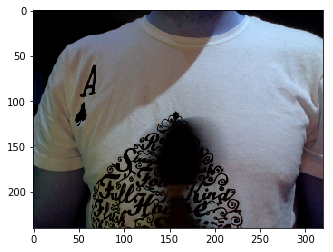

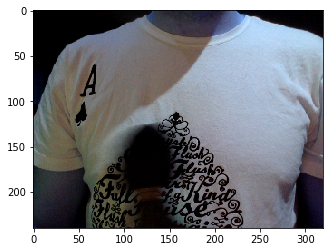

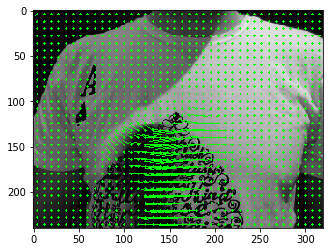

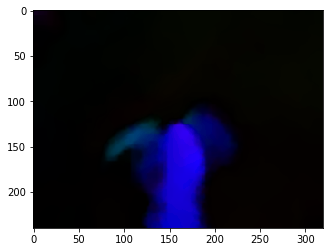

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


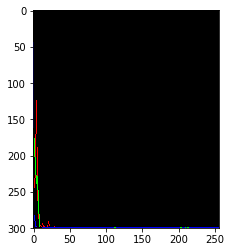

In [13]:
ret, prev = cam.read()
ret, img = cam.read()
prevgray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(prev)
plt.show()
plt.imshow(img)
plt.show()

flow = inst.calc(prevgray, gray, None)

d_flow = draw_flow(gray, flow, step=8)
plt.imshow(d_flow)
plt.show()

hsv_flow = draw_hsv(flow)
plt.imshow(hsv_flow)
plt.show()

plt.imshow(hist_curve(hsv_flow))
plt.show()

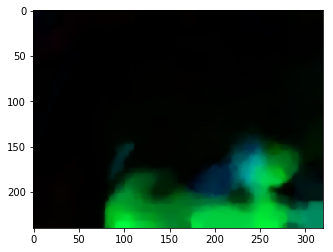

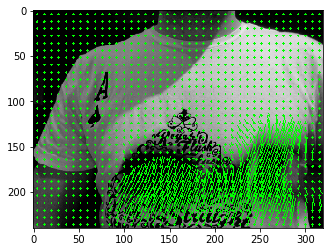

array([  0, 260,  10,   0,   8,  42])

In [25]:
ret, prev = cam.read()
ret, img = cam.read()
prevgray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

hsv_flow = draw_hsv(flow)
plt.imshow(hsv_flow)
plt.show()

flow = inst.calc(prevgray, gray, None)

d_flow = draw_flow(gray, flow, step=8)
plt.imshow(d_flow)
plt.show()

flow_directions(flow)

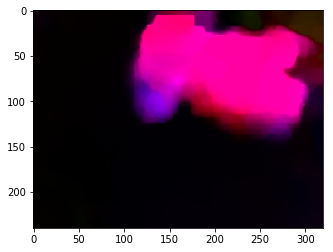

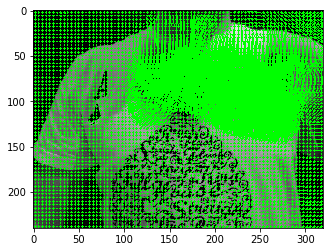

array([  0,  87,   0,   0, 102, 131])

In [29]:
ret, img1 = cam.read()
ret, img2 = cam.read()
ret, img3 = cam.read()
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
gray3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)

flow = inst.calc(gray1, gray2, None)
flow = inst.calc(gray2, gray3, warp_flow(flow,flow))

hsv_flow = draw_hsv(flow)
plt.imshow(hsv_flow)
plt.show()

d_flow = draw_flow(gray3, flow, step=4)
plt.imshow(d_flow)
plt.show()

flow_directions(flow)

In [16]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
# import cv2
import time
output_notebook()

from IPython.display import display, clear_output

from simplecoremidi import send_midi

# cap = cv2.VideoCapture(0)
ret, frame = cam.read()
frame=cv.cvtColor(frame, cv.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
frame=cv.flip(frame, -1) # because Bokeh flips vertically
width=frame.shape[1]
height=frame.shape[0]
p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
show(p, notebook_handle=True)
while True:
    ret, img1 = cam.read()
    ret, img2 = cam.read()
    ret, img3 = cam.read()
    gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    gray3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)

    flow = inst.calc(gray1, gray2, None)
    flow = inst.calc(gray2, gray3, warp_flow(flow,flow))

    hsv_flow = draw_hsv(flow)

    directions = flow_directions(flow)
    
#     for i, d in enumerate(directions):
#         send_midi((0x90|i,
#                    d,
#                    127))
#         sleep(0.1)
#         send_midi((0x90|i,
#                    d,
#                    0))
     
    
    hsv_flow=cv.flip(hsv_flow, 1)    
    font = cv.FONT_HERSHEY_SIMPLEX
    color = (0, 255, 0)    
    cv.putText(hsv_flow, "{}".format(directions), (0, 30), font, .5, color)
    
    hsv_flow=cv.flip(hsv_flow, 0)    
    frame=cv.cvtColor(hsv_flow, cv.COLOR_BGR2RGBA)
        
    myImage.data_source.data['image']=[frame]
    push_notebook()
#     time.sleep(0.1)

Loading BokehJS ...

KeyboardInterrupt: 

In [ ]:
# testing function
# from numpy.random import uniform
# pts = uniform(0,360,size=(1000000))
# vel = uniform(0,255,size=(1000000))
# direc = fangle_to_direction_simple(pts, vel)
# dir = np.histogram(direc, bins=[-2, -1, 1, 2, 3, 4, 4])[0]
# print(dir)
# plt.plot(dir)